0) **Imports**

In [30]:
import os, sys
from timeit import default_timer as timer
import dolfin as df # Fenics : dolfin + ufl + FIAT + ...
import numpy as np
import matplotlib.pyplot as plt
import copy 

1) **Consititutive behaviour Definition**

shuffling
Error C estimation (SVD): 2.9953516134118426e-10


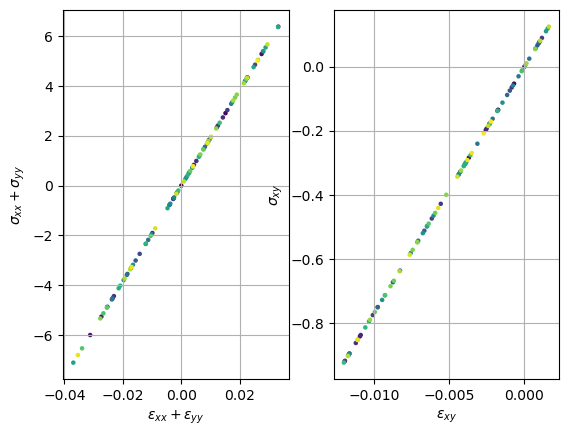

In [54]:
# fetricks is a set of utilitary functions to facilitate our lives
from fetricks.mechanics.elasticity_conversions import youngPoisson2lame
from ddfenics.dd.ddmaterial import DDMaterial 

database_file = 'database_generated.txt'

Nd = 100 # number of points
noise = 0.0
eps_range = np.array([[-0.03,0.03], [-0.009, 0.009], [-0.012, 0.002]]).T
E = 100.0
nu = 0.3

lamb, mu = youngPoisson2lame(nu, E) 
Cmat = np.array( [[lamb + 2*mu, lamb, 0], [lamb, lamb + 2*mu, 0], [0, 0, 2*mu]] )

np.random.seed(1)
DD = np.zeros((Nd,2,3))

for i in range(Nd):
    DD[i,0,:] = eps_range[0,:] + np.random.rand(3)*(eps_range[1,:] - eps_range[0,:])
    DD[i,1,:] = Cmat@DD[i,0,:] + noise*np.random.randn(3)
    
np.savetxt(database_file, DD.reshape((-1,6)), header = '1.0 \n%d 2 3 3'%Nd, comments = '', fmt='%.8e', )

ddmat = DDMaterial(database_file)  # replaces sigma_law = lambda u : ...

ddmat.plotDB()

print("Error C estimation (SVD):", np.linalg.norm(Cmat - ddmat.C)/np.linalg.norm(Cmat))
assert np.allclose(Cmat, ddmat.C,atol = 1.e-7)

2) **Mesh** (Unchanged) 

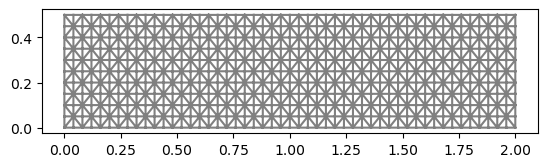

In [27]:
Nx =  50 # x10
Ny =  10 # x10
Lx = 2.0
Ly = 0.5
mesh = df.RectangleMesh(df.Point(0.0,0.0) , df.Point(Lx,Ly), Nx, Ny, 'left/right');
df.plot(mesh);

3) **Mesh regions** (Unchanged)

In [28]:
leftBnd = df.CompiledSubDomain('near(x[0], 0.0) && on_boundary')
rightBnd = df.CompiledSubDomain('near(x[0], Lx) && on_boundary', Lx=Lx)

clampedBndFlag = 1
loadBndFlag = 2
boundary_markers = df.MeshFunction("size_t", mesh, dim=1, value=0)
leftBnd.mark(boundary_markers, clampedBndFlag)
rightBnd.mark(boundary_markers, loadBndFlag)

dx = df.Measure('dx', domain=mesh)
ds = df.Measure('ds', domain=mesh, subdomain_data=boundary_markers)

4) **Spaces** (Unchanged)

In [29]:
Uh = df.VectorFunctionSpace(mesh, "Lagrange", 1) # Unchanged
bcL = df.DirichletBC(Uh, df.Constant((0.0, 0.0)), boundary_markers, clampedBndFlag) # Unchanged

# Space for stresses and strains
Sh0 = df.VectorFunctionSpace(mesh, 'DG', degree = 0 , dim = 3) 

5) **Variational Formulation**: <br>

- Strong format: 
$$
\begin{cases}
div \sigma = 0  \text{in} \, \Omega \\
u = 0 \quad \text{on} \, \Gamma_1 \\
\varepsilon = \nabla^s u \quad \text{in} \, \Omega \\
\sigma  n  = t \quad \text{on} \, \Gamma_2 \\
\end{cases}
$$ 
- DD equilibrium subproblem: Given $(\varepsilon^*, \sigma^*) \in Z_h$, solve for $(u,\eta) \in U_h$  
$$
\begin{cases}
(\mathbb{C} \nabla^s u , \nabla^s v ) = (\mathbb{C} \varepsilon^* , \nabla^s v ) \quad \forall v \in U_h, \\
(\mathbb{C} \nabla^s \eta , \nabla^s \xi ) = \Pi_{ext}(\xi) - (\sigma^* , \nabla^s \xi ) \quad \forall \xi \in U_h \\
\end{cases}
$$
- Updates:
$$
\begin{cases}
\varepsilon = \nabla^s u \\
\sigma = \sigma^* + \mathbb{C} \nabla^s \eta
\end{cases}
$$
- DD ''bilinear'' form : $(\bullet , \nabla^s v)$ or sometimes  $(\mathbb{C} \nabla^s \bullet, \nabla^s v)$ 

In [55]:
from ddfenics.dd.ddbilinear import DDBilinear

# Unchanged
ty = -0.1
traction = df.Constant((0.0, ty))

u = df.TrialFunction(Uh) 
v = df.TestFunction(Uh)
b = df.inner(traction,v)*ds(loadBndFlag)

a = DDBilinear(ddmat, dx, u, v) # replaces df.inner(sig(u) , df.grad(v))*dx

6) **Statement and Solving the problem** <br> 
- DDProblem : States DD equilibrium subproblem and updates.
- DDSolver : Implements the alternate minimization using SKlearn NearestNeighbors('ball_tree', ...) searchs for the projection onto data.
- Stopping criteria: $\|d_k - d_{k-1}\|/energy$

In [62]:
from ddfenics.dd.ddfunction import DDFunction
from ddfenics.dd.ddmetric import DDMetric
from ddfenics.dd.ddproblem import DDProblem
from ddfenics.dd.ddsolver import DDSolver

# Extended solution : replaces u = df.Function(Uh)
sol = {"state_mech" : [DDFunction(Sh0), DDFunction(Sh0)], # mechanical states (eps, sig)
       "state_db": [DDFunction(Sh0), DDFunction(Sh0)],  # database states (eps, sig)
       "u" : df.Function(Uh)} # displacemens

# DD global and local distance
dddist = DDMetric(ddmat.C, V = Sh0, dx = dx)

# replaces df.LinearVariationalProblem(a, b, uh, bcs = [bcL])
problem = DDProblem(a, b, sol, [bcL], metric = dddist) 

start = timer()

#replaces df.LinearVariationalSolver(problem)
solver = DDSolver(problem, opInit = 'random', seed = 1)
tol_ddcm = 1e-7
solver.solve(tol = tol_ddcm, maxit = 100);

end = timer()

uh = sol["u"]
normL2 = df.assemble(df.inner(uh,uh)*dx)
norm_energy = df.assemble(df.inner(sol['state_mech'][0],sol['state_mech'][1])*dx)

print("Time spent: ", end - start)
print("Norm L2: ", normL2)
print("Norm energy: ", norm_energy)

assert np.allclose(normL2, 0.0027947522851385622)
assert np.allclose(norm_energy, 0.005346914742672427)

	Inner Iteration #  1 ,- Relative Error =  4.764992e-01
	Inner Iteration #  2 ,- Relative Error =  7.844195e-02
	Inner Iteration #  3 ,- Relative Error =  1.381604e-02
	Inner Iteration #  4 ,- Relative Error =  0.000000e+00
Time spent:  0.060636787999101216
Norm L2:  0.0027947522851385622
Norm energy:  0.005346914742672427


7) **Plotting**

a) *Minimisation*

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


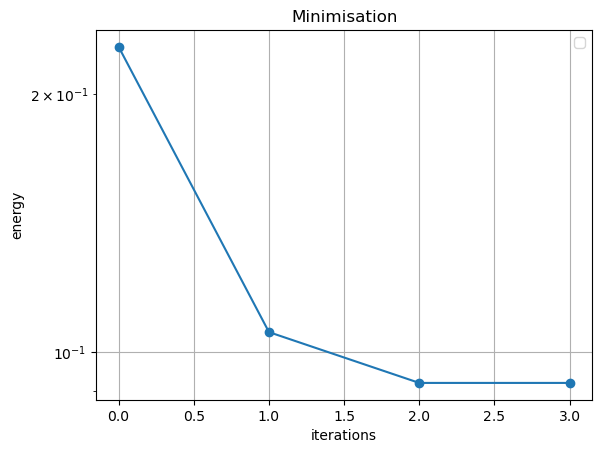

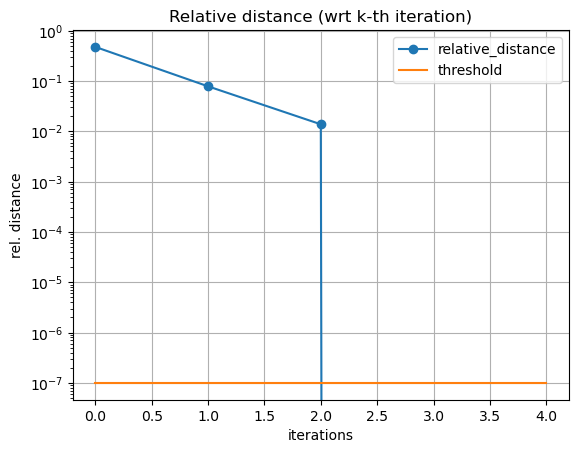

In [57]:
hist = solver.hist

fig = plt.figure(1)
plt.title('Minimisation')
plt.plot(hist['relative_energy'], 'o-')
plt.xlabel('iterations')
plt.ylabel('energy')
plt.legend(loc = 'best')
plt.yscale('log')
plt.grid()

fig = plt.figure(2)
plt.title('Relative distance (wrt k-th iteration)')
plt.plot(hist['relative_distance'], 'o-', label = "relative_distance")
plt.plot([0,len(hist['relative_energy'])],[tol_ddcm,tol_ddcm], label = "threshold")
plt.yscale('log')
plt.xlabel('iterations')
plt.ylabel('rel. distance')
plt.legend(loc = 'best')
plt.grid()

b) *Data Convergence*

shuffling
	Inner Iteration #  1 ,- Relative Error =  9.309215e-01
	Inner Iteration #  2 ,- Relative Error =  4.173316e-02
	Inner Iteration #  3 ,- Relative Error =  7.715994e-04
	Inner Iteration #  4 ,- Relative Error =  0.000000e+00
shuffling
	Inner Iteration #  1 ,- Relative Error =  4.764992e-01
	Inner Iteration #  2 ,- Relative Error =  7.844195e-02
	Inner Iteration #  3 ,- Relative Error =  1.381604e-02
	Inner Iteration #  4 ,- Relative Error =  0.000000e+00
shuffling
	Inner Iteration #  1 ,- Relative Error =  4.764992e-01
	Inner Iteration #  2 ,- Relative Error =  7.844195e-02
	Inner Iteration #  3 ,- Relative Error =  1.381604e-02
	Inner Iteration #  4 ,- Relative Error =  0.000000e+00
shuffling
	Inner Iteration #  1 ,- Relative Error =  4.764992e-01
	Inner Iteration #  2 ,- Relative Error =  7.844195e-02
	Inner Iteration #  3 ,- Relative Error =  1.381604e-02
	Inner Iteration #  4 ,- Relative Error =  0.000000e+00
shuffling
	Inner Iteration #  1 ,- Relative Error =  4.764992e-0

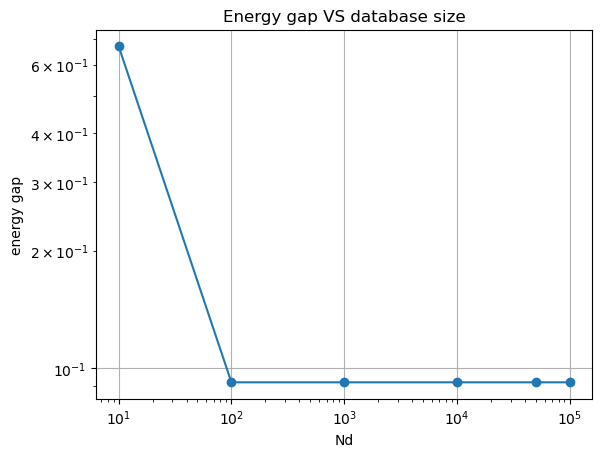

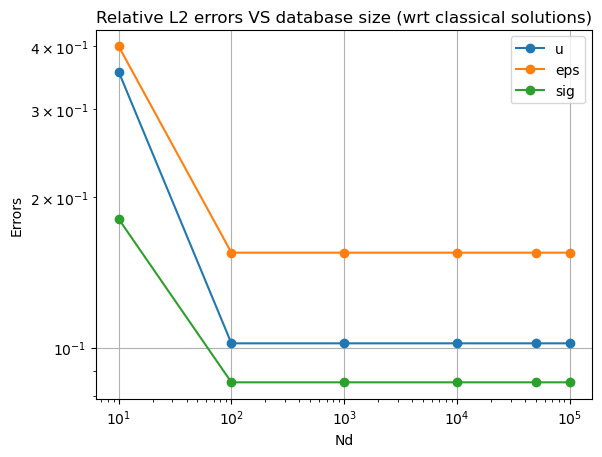

In [9]:
relative_norm = lambda x1, x0: np.sqrt(df.assemble( df.inner(x1 - x0, x1 - x0)*dx ) )/np.sqrt(df.assemble( df.inner(x0, x0)*dx ) )

Nd_list = [10,100, 1000, 10000, 50000, 100000] 
hist_list = []
error_u = []
error_eps = []
error_sig = []

sol_ref_file =  df.XDMFFile("bar_sol.xdmf")
sol_ref = {"state" : [DDFunction(Sh0), DDFunction(Sh0)], "u" : df.Function(Uh)}   
sol_ref_file.read_checkpoint(sol_ref["u"],"u")
sol_ref_file.read_checkpoint(sol_ref["state"][0],"eps")
sol_ref_file.read_checkpoint(sol_ref["state"][1],"sig")

np.random.seed(1)


for Nd_i in Nd_list:
    indexes = np.arange(0,Nd).astype('int')
    np.random.shuffle(indexes)
    DD_i = DD[indexes[:Nd_i], : , : ]
    ddmat_i = DDMaterial(DD_i)
    
    a_i = DDBilinear(ddmat_i, dx, u, v) 

    sol_i = {"state_mech" : [DDFunction(Sh0), DDFunction(Sh0)], # mechanical states (eps, sig)
           "state_db": [DDFunction(Sh0), DDFunction(Sh0)],  # database states (eps, sig)
           "u" : df.Function(Uh)} # displacemens
    
    problem_i = DDProblem(a_i, b, sol_i, [bcL], metric = DDMetric(ddmat_i.C, V = Sh0, dx = dx)) 
    solver_i = DDSolver(problem_i, opInit = 'random', seed = 1)
    solver_i.solve(tol = tol_ddcm, maxit = 100)
    
    hist_list.append(copy.deepcopy(solver_i.hist))
    
    error_u.append(relative_norm(sol_i["u"], sol_ref["u"])) 
    error_eps.append(relative_norm(sol_i["state_mech"][0], sol_ref["state"][0])) 
    error_sig.append(relative_norm(sol_i["state_mech"][1], sol_ref["state"][1]))
    
    
    
plt.figure(5)
plt.title('Energy gap VS database size')
plt.plot(Nd_list, [hist_list[i]['relative_energy'][-1] for i in range(len(Nd_list))], '-o')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Nd')
plt.ylabel('energy gap')
plt.grid()

plt.figure(6)
plt.title('Relative L2 errors VS database size (wrt classical solutions)')
plt.plot(Nd_list, error_u, '-o', label = 'u')
plt.plot(Nd_list, error_eps, '-o', label = 'eps')
plt.plot(Nd_list, error_sig, '-o', label = 'sig')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Nd')
plt.ylabel('Errors')
plt.legend(loc = 'best')
plt.grid()

8. **Sanity check:** : Recovering reference database

(1000, 6)
[-0.02294876 -0.00840356 -0.00677863]
[0.02294876 0.00840356 0.0011281 ]
shuffling


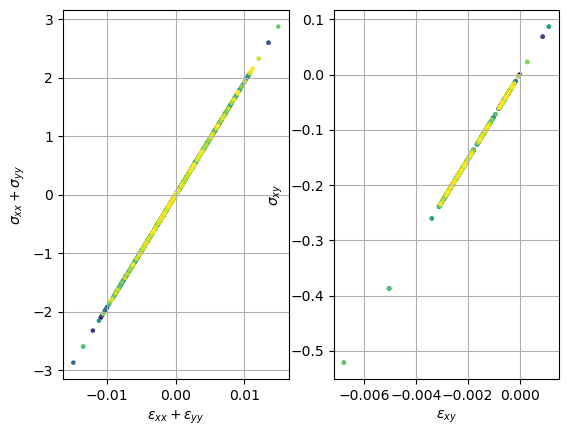

In [21]:
from ddfenics.dd.ddfunction import DDFunction

data = np.concatenate((sol_ref["state"][0].vector().get_local().reshape((-1,3)), 
                       sol_ref["state"][1].vector().get_local().reshape((-1,3))), axis = 1)

print(data.shape)
print(np.min(data[:,:3], axis = 0) )
print(np.max(data[:,:3], axis = 0) )

np.savetxt('database_ref.txt', data, header = '1.0 \n%d 2 3 3'%data.shape[0], comments = '', fmt='%.8e')
ddmat = DDMaterial('database_ref.txt') 
ddmat.plotDB()
# After re-execute blocks 5 and 6, the error should be zero machine